In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

In [2]:
# compute patient heterogeneity of each pre-QC TOPACIO cluster

save_dir = (
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/' +
    'TOPACIO_FINAL/output_raw/clustering/2d/cluster_barcharts'
    )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df = pd.read_parquet(
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/TOPACIO_FINAL/' +
    'output_raw/checkpoints/clustering.parquet'
    )

df = df[df['cluster_2d'] != -1]

mydict = {}
for name, group in df.groupby(['cluster_2d']):
    mydict[name[0]] = round(((group['Sample'].nunique() / df['Sample'].nunique()) * 100), 3)

min_key = min(mydict, key=lambda k: mydict[k])
max_key = max(mydict, key=lambda k: mydict[k])

print(
    f'Cluster with smallest specimen diversity is {min_key} with {mydict[min_key]}% of specimens.'
)
print(
    f'Cluster with largest specimen diversity is {max_key} with {mydict[max_key]}% of specimens.'
)

single_sample_clusters = [key for key, value in mydict.items() if value == 4.0]
print(f'Single sample clusters are {single_sample_clusters}.')

sorted_dict = dict(sorted(mydict.items(), key=lambda item: item[1]))

Cluster with smallest specimen diversity is 75 with 4.0% of specimens.
Cluster with largest specimen diversity is 0 with 100.0% of specimens.
Single sample clusters are [75, 126, 127, 146, 152].


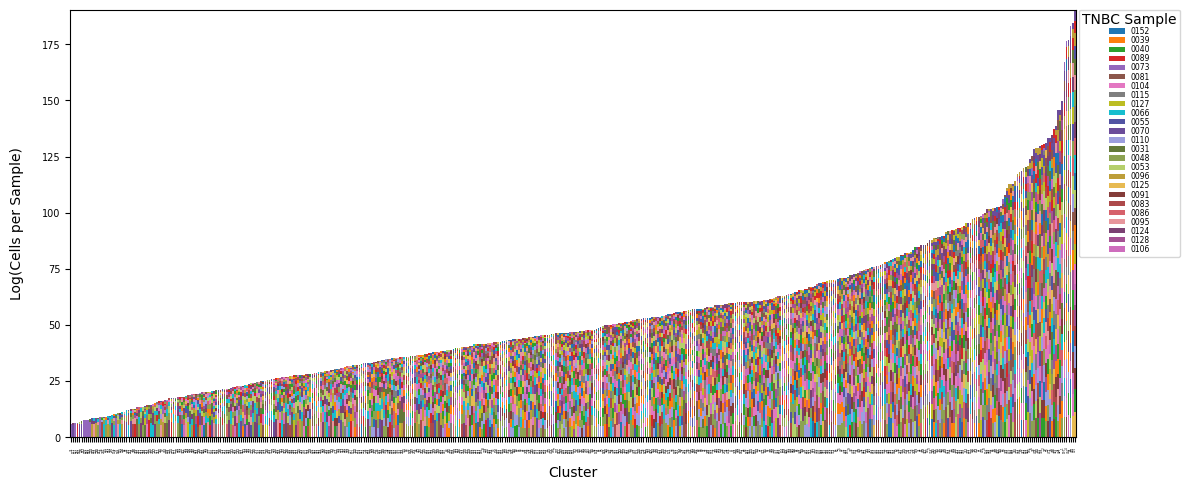

In [3]:
# plot stacked bar chart of all pre-QC TOPACIO clusters together
plot_input = df.groupby(['cluster_2d', 'Sample']).size()

plot_input = np.log(plot_input) # taking log to compress y-axis data range for plotting
plot_input = plot_input.unstack()
plot_input = plot_input.fillna(value=0.0)

plot_input.columns = [i.split('_')[1] for i in plot_input.columns]

# have to convert cluster integers to strings to get plot to sort by bar height
plot_input.index = [str(i) for i in plot_input.index]

# sort clusters by the degree of their sample representation
plot_input = plot_input.reindex(plot_input.sum(axis=1).sort_values().index)

fig, ax = plt.subplots(figsize=(12, 5))

indexes = np.argsort(plot_input.values).T
heights = np.sort(plot_input.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

# List of 30 tab-like hexadecimal colors
hex_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#5254a3', '#6b4c9a', '#9c9ede', '#637939', '#8ca252',
              '#b5cf6b', '#bd9e39', '#e7ba52', '#843c39', '#ad494a',
              '#d6616b', '#e7969c', '#7b4173', '#a55194', '#ce6dbd',
              '#de9ed6', '#ff9888', '#8e6d8e', '#c49c94', '#d7b5a6']

# Convert hexadecimal colors to RGB values
cmap = [mcolors.to_rgba(color) for color in hex_colors]

mpp_colors = dict(zip(plot_input.columns, cmap))

for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):
    mps = np.take(np.array(plot_input.columns), idxs)
    ax.bar(
        x=plot_input.index, height=vals, width=0.9, lw=0.0,
        bottom=bottoms[btms], color=[mpp_colors[m] for m in mps]
    )
ax.set_xlabel('Cluster', size=10, labelpad=10)
ax.set_ylabel('Log(Cells per Sample)', size=10, labelpad=13, c='k')
ax.tick_params(axis='x', which='major', labelsize=2, rotation=90)
ax.tick_params(axis='y', which='major', labelsize=7)
ax.margins(x=0)

markers = [
    Patch(facecolor=color, edgecolor=None) for color in mpp_colors.values()
]
plt.legend(
    markers, mpp_colors.keys(), title='TNBC Sample', prop={'size': 5.5},
    labelspacing=0.01, loc='upper left', bbox_to_anchor=(1.0, 1.01)
)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'topacio_samples_per_cluster.pdf'))
plt.show()
plt.close('all')

Cluster: 0


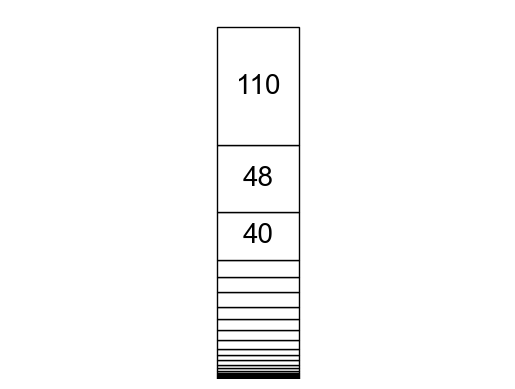

Cluster: 1


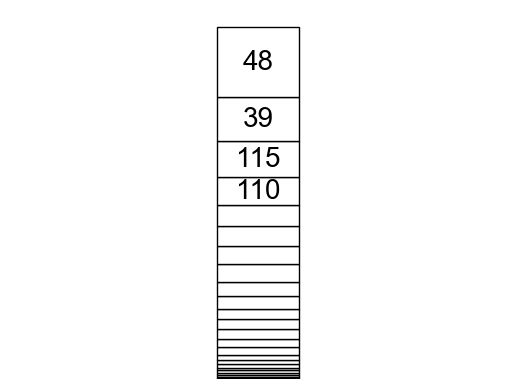

Cluster: 2


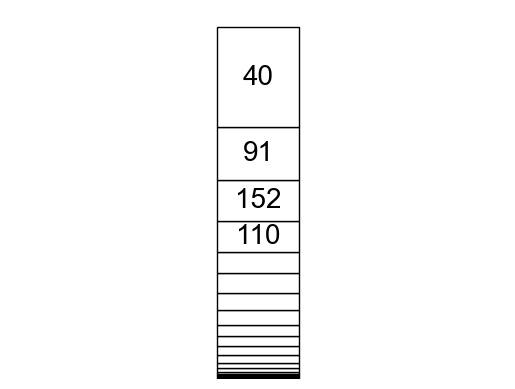

Cluster: 4


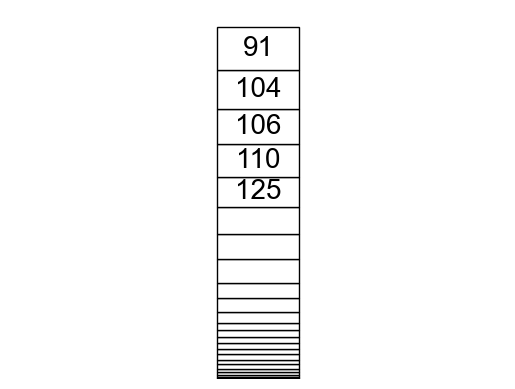

Cluster: 6


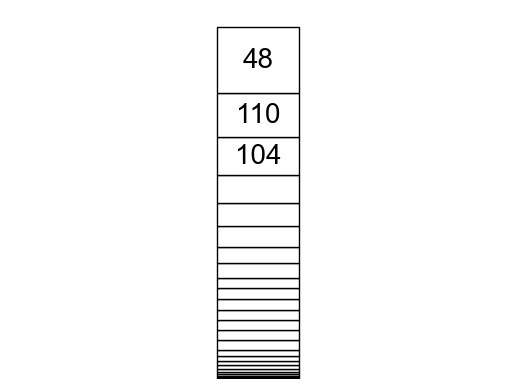

Cluster: 11


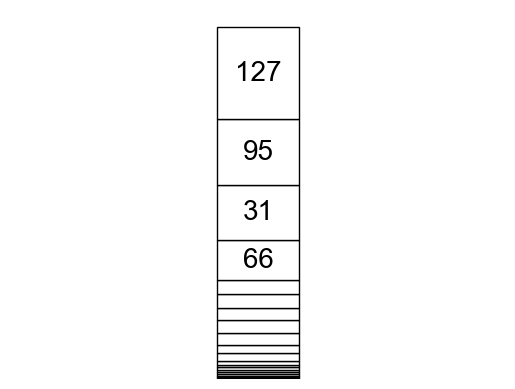

Cluster: 14


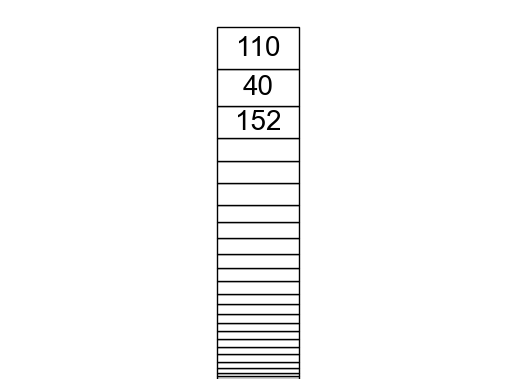

Cluster: 15


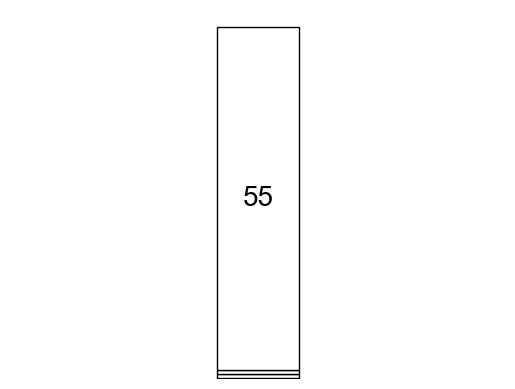

Cluster: 19


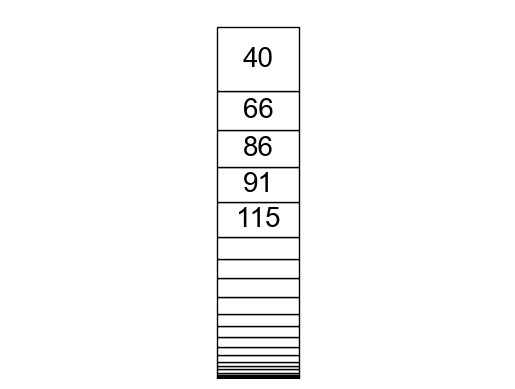

Cluster: 21


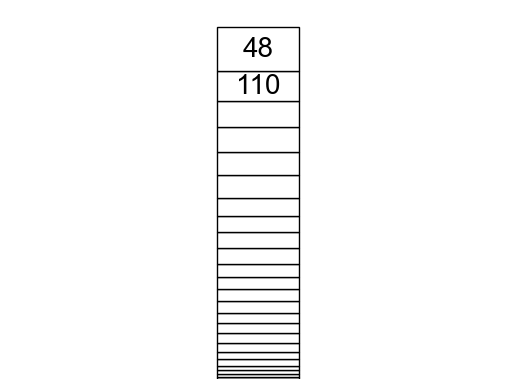

Cluster: 28


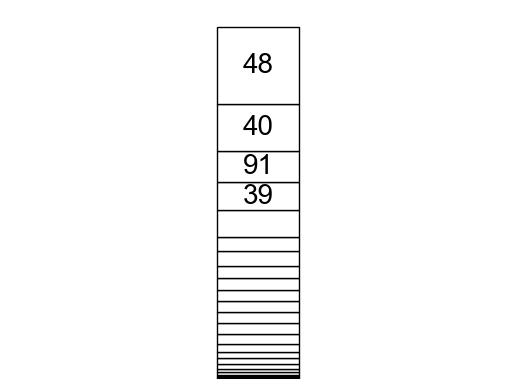

Cluster: 77


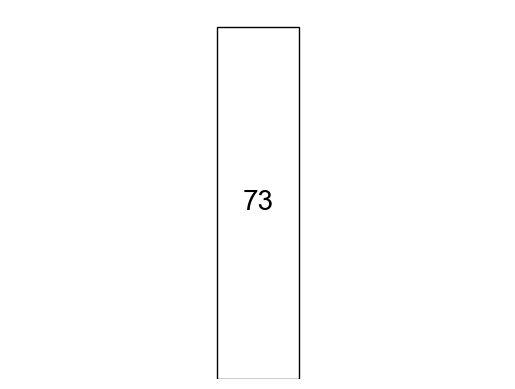

Cluster: 79


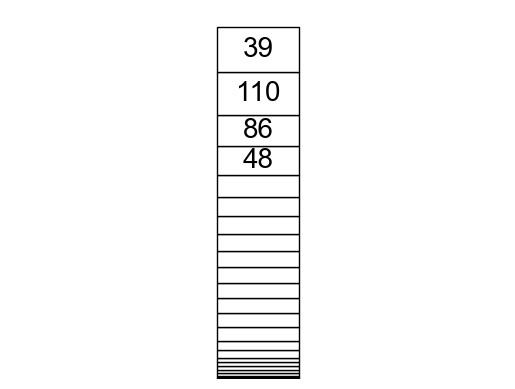

Cluster: 89


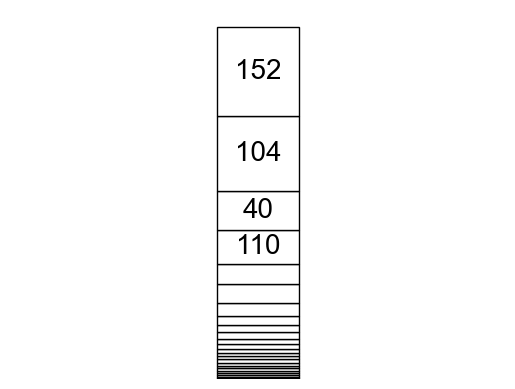

Cluster: 110


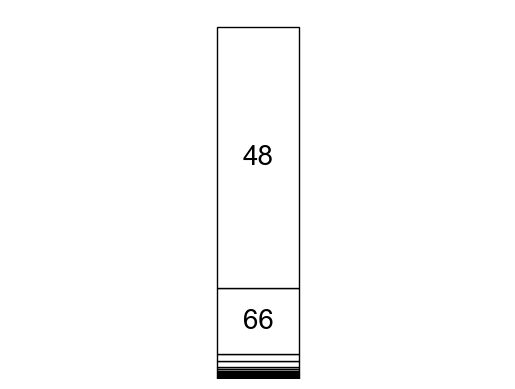

Cluster: 118


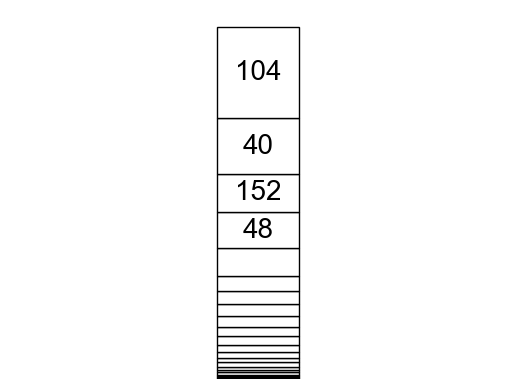

Cluster: 166


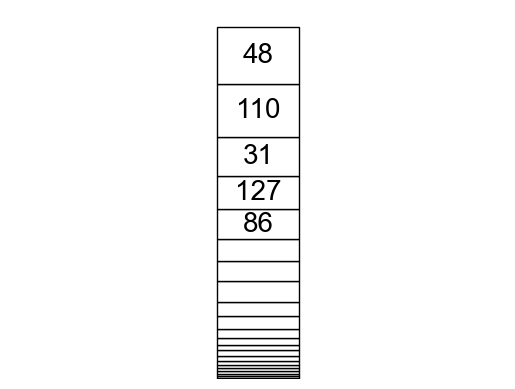

Cluster: 174


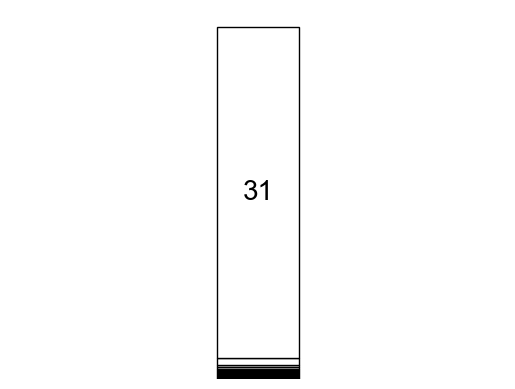

Cluster: 177


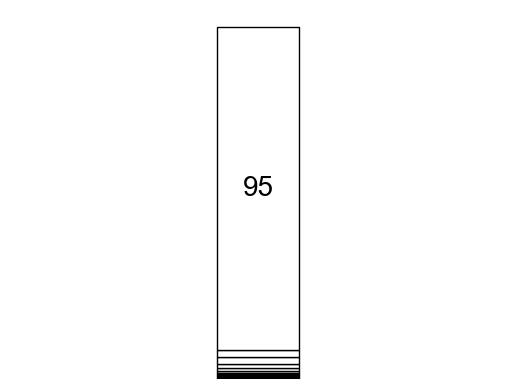

Cluster: 187


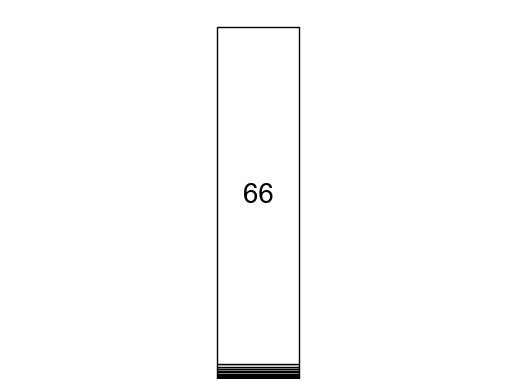

Cluster: 197


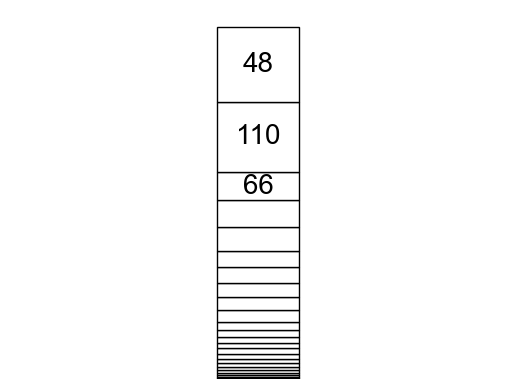

Cluster: 205


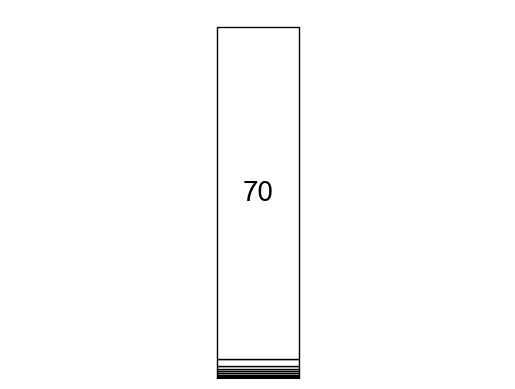

Cluster: 215


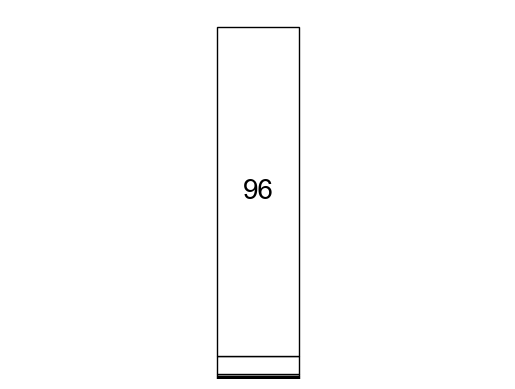

Cluster: 237


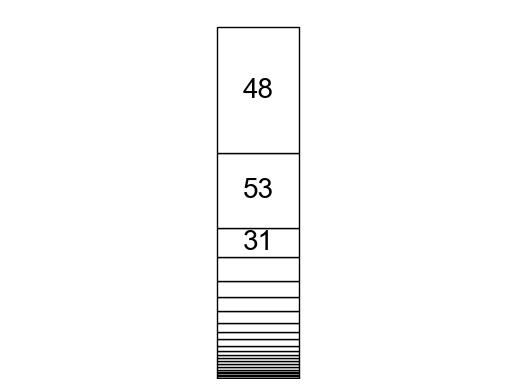

Cluster: 268


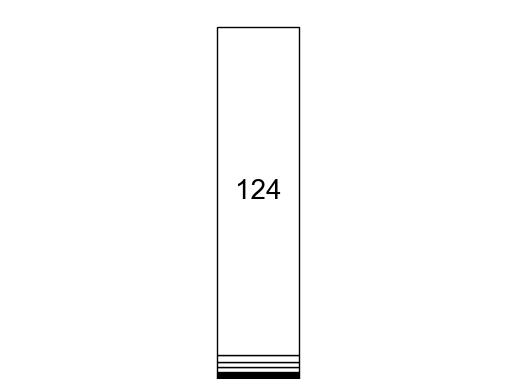

Cluster: 269


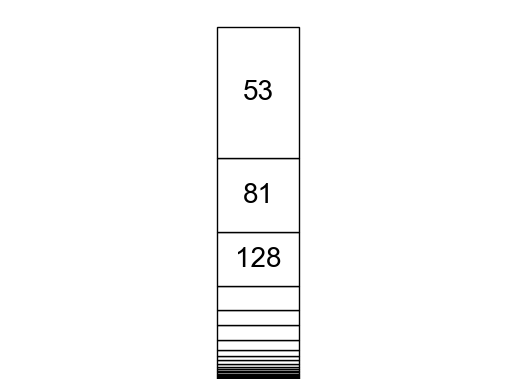

Cluster: 272


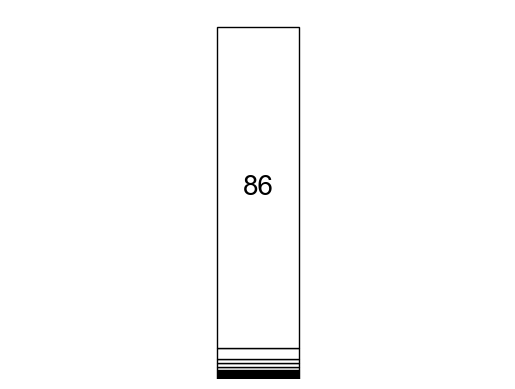

Cluster: 309


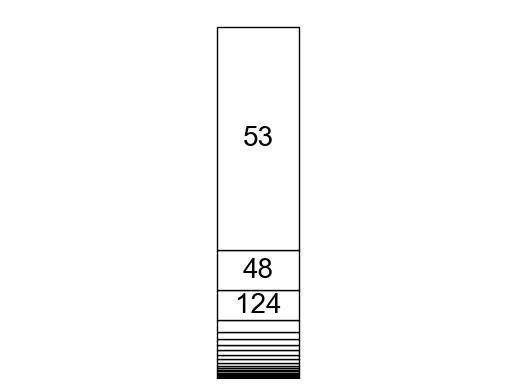

Cluster: 312


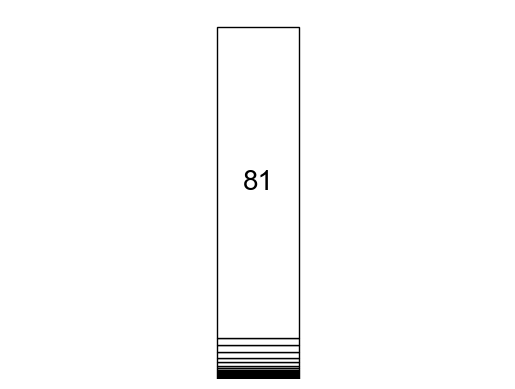

Cluster: 324


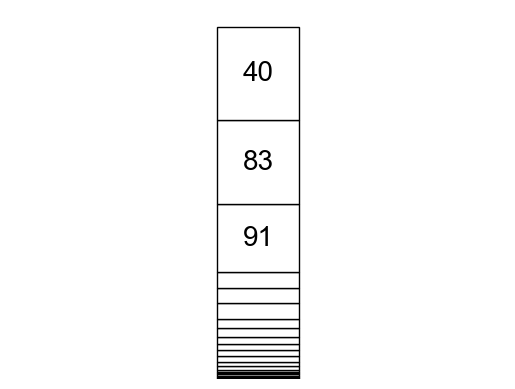

Cluster: 328


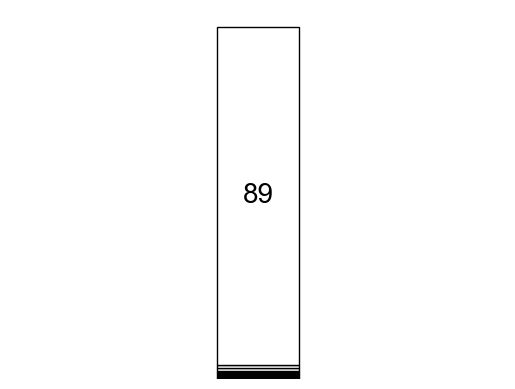

Cluster: 336


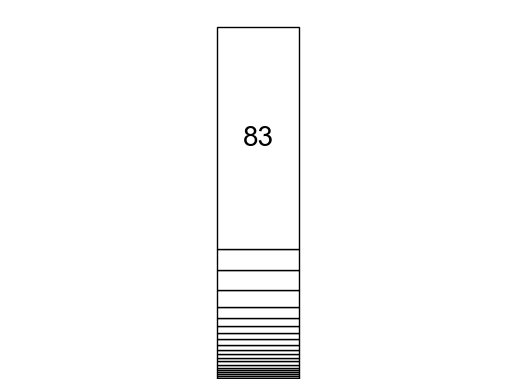

Cluster: 341


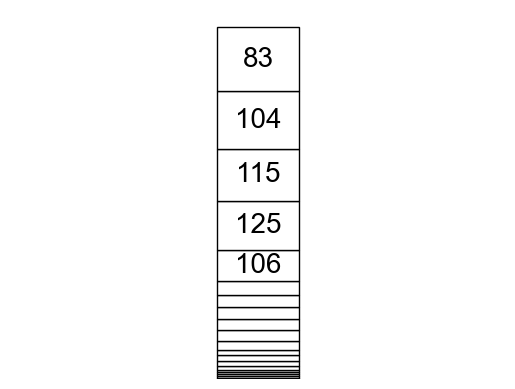

Cluster: 383


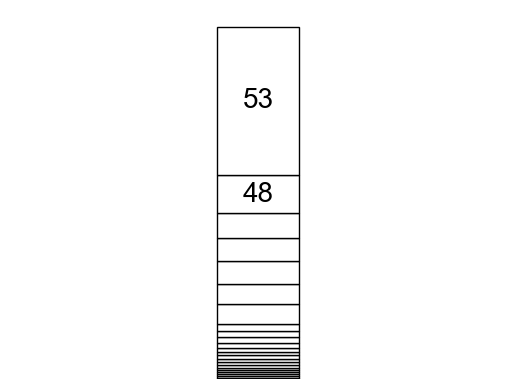

Cluster: 404


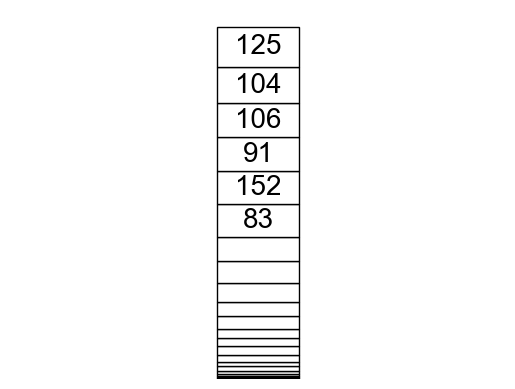

Cluster: 405


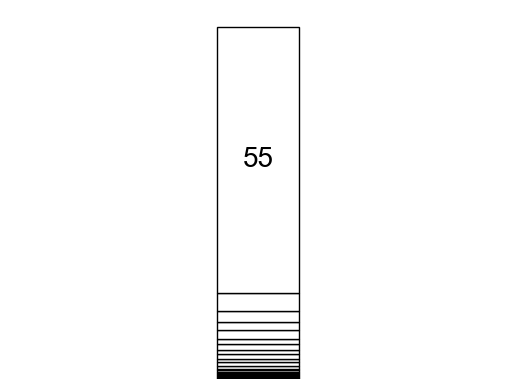

Cluster: 408


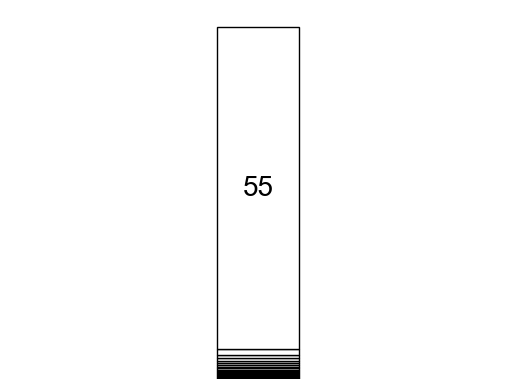

Cluster: 415


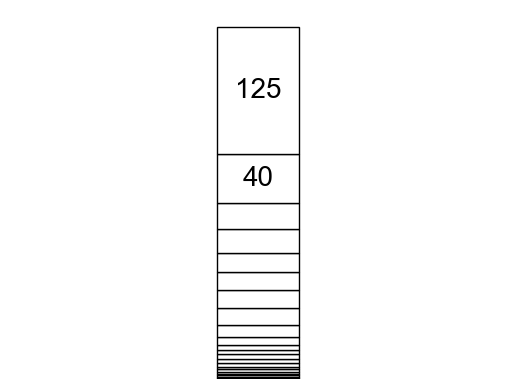

Cluster: 424


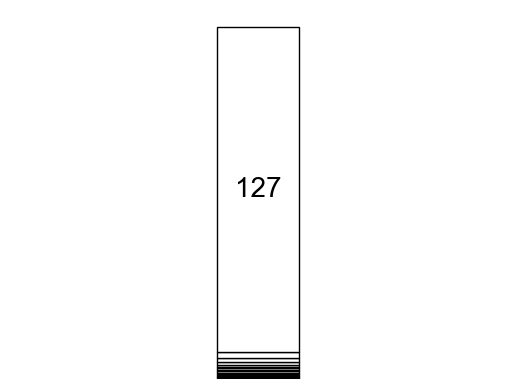

Cluster: 427


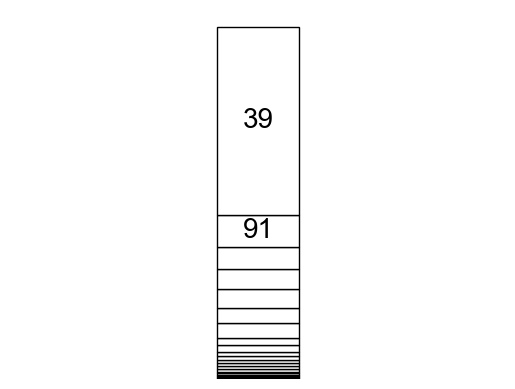

Cluster: 437


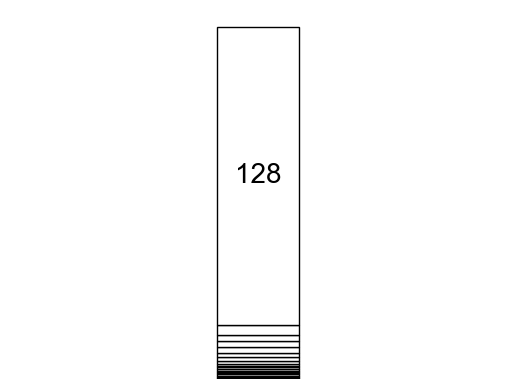

Cluster: 444


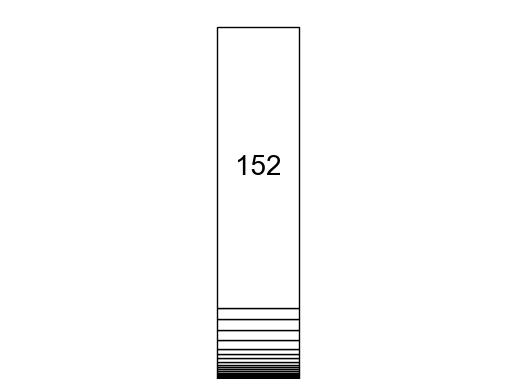

Cluster: 465


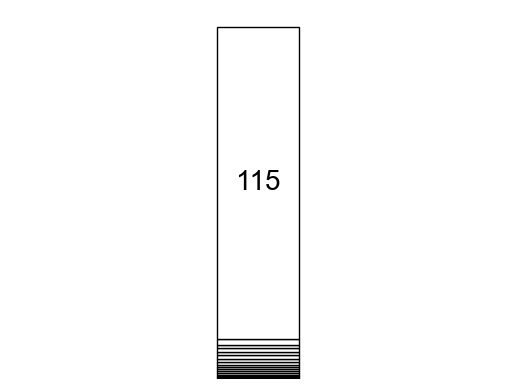

Cluster: 466


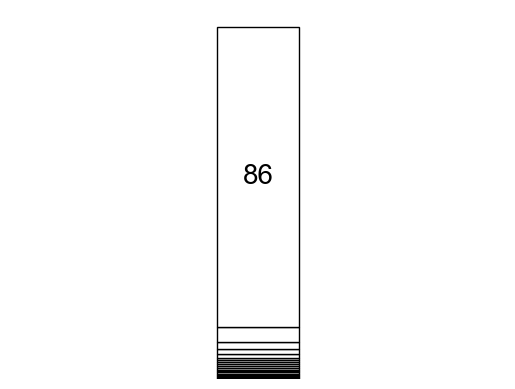

Cluster: 477


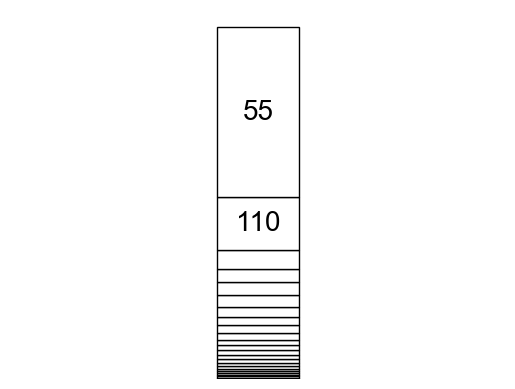

Cluster: 478


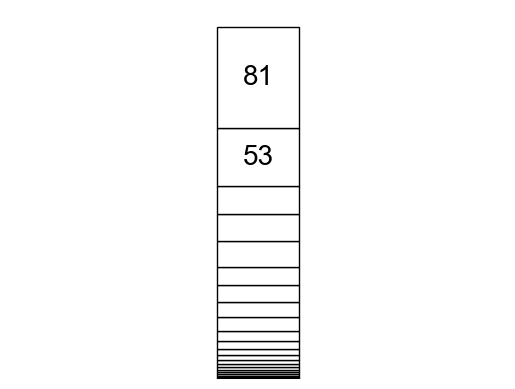

Cluster: 480


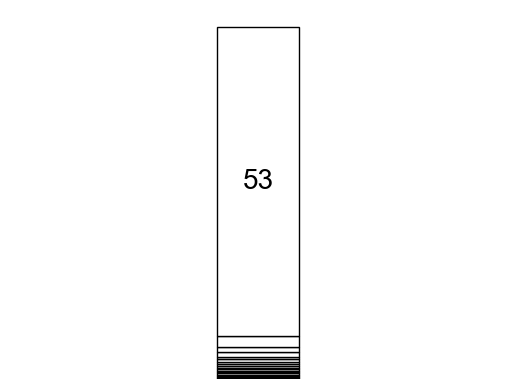

Cluster: 491


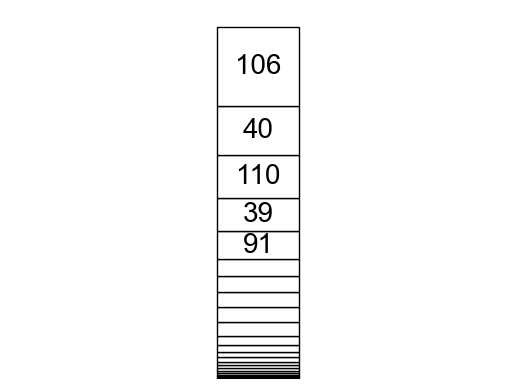

In [4]:
# visualize stacked bar charts of pre-QC TOPACIO cluster heterogeneity

my_clusters = [
    0, 1, 2, 4, 6, 11, 14, 15, 19, 21, 28, 77, 79, 89, 110, 118,
    166, 174, 177, 187, 197, 205, 215, 237, 268, 269, 272, 309, 312, 324, 328,
    336, 341, 383, 404, 405, 408, 415, 424, 427, 437, 444, 465, 466, 477, 478,
    480, 491
    ]

df = df[df['cluster_2d'].isin(my_clusters)]

for cluster in sorted(df['cluster_2d'].unique()):
    test = df[df['cluster_2d'] == cluster]
    plot = test.groupby('Sample').size().sort_values()
    plot = pd.DataFrame(plot/plot.sum()).T
    plot.columns = [i.split('_')[1].lstrip('0') for i in plot.columns]

    ax = plot.plot(
        kind='bar', width=0.1, stacked=True, color='w', edgecolor='k'
        )

    pos = -1
    for i, bar in enumerate(ax.patches):
        if i % len(plot.index) == 0:
            pos += 1
        xloc = bar.get_x() + 0.05
        yloc = bar.get_y() + bar.get_height()/2
        if bar.get_height() > 0.08:
            ax.annotate(
                str(plot.columns[pos]), xy=(xloc, yloc), fontname='Arial',
                va='center', ha='center', size=20
                )

    ax.get_legend().remove()
    ax.axis('off')
    
    print(f'Cluster: {cluster}')
    plt.savefig(os.path.join(save_dir, f'{cluster}_pie.pdf'))
    plt.show()
    plt.close('all')

In [ ]:
# compute patient heterogeneity of each post-QC TOPACIO cluster
save_dir = (
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/' +
    'TOPACIO_FINAL/output_orig/clustering/2d/cluster_barcharts'
    )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df = pd.read_parquet(
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/TOPACIO_FINAL/' +
    'output_orig/checkpoints/clustering.parquet'
    )

df = df[df['cluster_2d'] != -1]

mydict = {}
for name, group in df.groupby(['cluster_2d']):
    mydict[name[0]] = round(((group['Sample'].nunique() / df['Sample'].nunique()) * 100), 3)

min_key = min(mydict, key=lambda k: mydict[k])
max_key = max(mydict, key=lambda k: mydict[k])

print(
    f'Cluster with smallest specimen diversity is {min_key} with {mydict[min_key]}% of specimens.'
)
print(
    f'Cluster with largest specimen diversity is {max_key} with {mydict[max_key]}% of specimens.'
)

single_sample_clusters = [key for key, value in mydict.items() if value == 4.0]
print(f'Single sample clusters are {single_sample_clusters}.')

sorted_dict = dict(sorted(mydict.items(), key=lambda item: item[1]))

In [ ]:
# plot stacked bar chart of all pre-QC TOPACIO clusters together
plot_input = df.groupby(['cluster_2d', 'Sample']).size()

plot_input = plot_input.unstack()
plot_input = plot_input.fillna(value=0.0)

plot_input.columns = [i.split('_')[1] for i in plot_input.columns]

# have to convert cluster integers to strings to get plot to sort by bar height
plot_input.index = [str(i) for i in plot_input.index]

# sort clusters by the degree of their sample representation
plot_input = plot_input.reindex(plot_input.sum(axis=1).sort_values().index)

fig, ax = plt.subplots(figsize=(12, 5))

indexes = np.argsort(plot_input.values).T
heights = np.sort(plot_input.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

# List of 30 tab-like hexadecimal colors
hex_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#5254a3', '#6b4c9a', '#9c9ede', '#637939', '#8ca252',
              '#b5cf6b', '#bd9e39', '#e7ba52', '#843c39', '#ad494a',
              '#d6616b', '#e7969c', '#7b4173', '#a55194', '#ce6dbd',
              '#de9ed6', '#ff9888', '#8e6d8e', '#c49c94', '#d7b5a6']

# Convert hexadecimal colors to RGB values
cmap = [mcolors.to_rgba(color) for color in hex_colors]

mpp_colors = dict(zip(plot_input.columns, cmap))

for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):
    mps = np.take(np.array(plot_input.columns), idxs)
    ax.bar(
        x=plot_input.index, height=vals, width=0.9, lw=0.0,
        bottom=bottoms[btms], color=[mpp_colors[m] for m in mps]
    )
ax.set_xlabel('Cluster', size=10, labelpad=10)
ax.set_ylabel('Cells per Sample', size=10, labelpad=13, c='k')
ax.tick_params(axis='x', which='major', labelsize=2, rotation=90)
ax.tick_params(axis='y', which='major', labelsize=7)
ax.margins(x=0)

markers = [
    Patch(facecolor=color, edgecolor=None) for color in mpp_colors.values()
]
plt.legend(
    markers, mpp_colors.keys(), title='TNBC Sample', prop={'size': 5.5},
    labelspacing=0.01, loc='upper left', bbox_to_anchor=(1.0, 1.01)
)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'topacio_samples_per_cluster.pdf'))
plt.show()
plt.close('all')

In [ ]:
# visualize stacked bar charts of pre-QC TOPACIO cluster heterogeneity
for cluster in sorted(df['cluster_2d'].unique()):
    test = df[df['cluster_2d'] == cluster]
    plot = test.groupby('Sample').size().sort_values()
    plot = pd.DataFrame(plot/plot.sum()).T
    plot.columns = [i.split('_')[1].lstrip('0') for i in plot.columns]

    ax = plot.plot(
        kind='bar', width=0.1, stacked=True, color='w', edgecolor='k'
        )

    pos = -1
    for i, bar in enumerate(ax.patches):
        if i % len(plot.index) == 0:
            pos += 1
        xloc = bar.get_x() + 0.05
        yloc = bar.get_y() + bar.get_height()/2
        if bar.get_height() > 0.08:
            ax.annotate(
                str(plot.columns[pos]), xy=(xloc, yloc), fontname='Arial',
                va='center', ha='center', size=20
                )

    ax.get_legend().remove()
    ax.axis('off')
    
    print(f'Cluster: {cluster}')
    plt.savefig(os.path.join(save_dir, f'{cluster}_pie.pdf'))
    plt.show()
    plt.close('all')